# Findabetes model

* Dataset: CDC Diabetes Health Indicators

In [1]:
# Import necessary libraries
# Will need to go through this later and remove unused imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict

In [2]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)



{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [4]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [5]:
X.describe()


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [6]:
X.dtypes

HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

In [7]:
y.dtypes

Diabetes_binary    int64
dtype: object

In [8]:
y.isna().sum()

Diabetes_binary    0
dtype: int64

In [9]:
X.isna().sum()



HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

# Feature selection

**Features that are less relevant for a Swedish context**

* AnyHealthcare - in most Swedish regions, all patients listed at a primary health clinic will be covered by subsidised healthcare. This project will take placce in Stockholm, where you have to be folkbokförd to belong to a primary clinic[1], meaning all patients at the clinic are eligable for subsidised health care [2].
* NoDocbcCost - Same reasoning as above
* Income - may not be irrelevant, but would need to be adapted to a Swedish context. It is likely that the correlation between income level and diabetes risk is not the same in Sweden as in the United States. Since this dataset reflects U.S. income thresholds, the feature is not directly relevant for our population and should therefore be excluded unless it can be replaced with a more context-appropriate measure.
* Education - same reasoning as above.

**Features where the patient is unlikely to know the answer**
* HighChol - need access to lab results/knowledge about results.
* CholCheck - All patients may not be aware of whether or not their cholesterol has been tested or when it was done most recently.
* BMI - should not be excluded, but the patient may not be aware of their BMI, and it may be useful to add a bmi-calculator to the dashboard.


In [10]:
X = X.drop(columns=['AnyHealthcare', 'NoDocbcCost', 'Income', 'Education', 'HighChol', 'CholCheck'])
X.head()

,HighBP,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,1,40,1,0,0,0,0,1,0,5,18,15,1,0,9
1,0,25,1,0,0,1,0,0,0,3,0,0,0,0,7
2,1,28,0,0,0,0,1,0,0,5,30,30,1,0,9
3,1,27,0,0,0,1,1,1,0,2,0,0,0,0,11
4,1,24,0,0,0,1,1,1,0,2,3,0,0,0,11


# EDA

In [11]:
df = pd.concat([X, y], axis=1)

In [12]:
df.head()

,HighBP,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Diabetes_binary
0,1,40,1,0,0,0,0,1,0,5,18,15,1,0,9,0
1,0,25,1,0,0,1,0,0,0,3,0,0,0,0,7,0
2,1,28,0,0,0,0,1,0,0,5,30,30,1,0,9,0
3,1,27,0,0,0,1,1,1,0,2,0,0,0,0,11,0
4,1,24,0,0,0,1,1,1,0,2,3,0,0,0,11,0


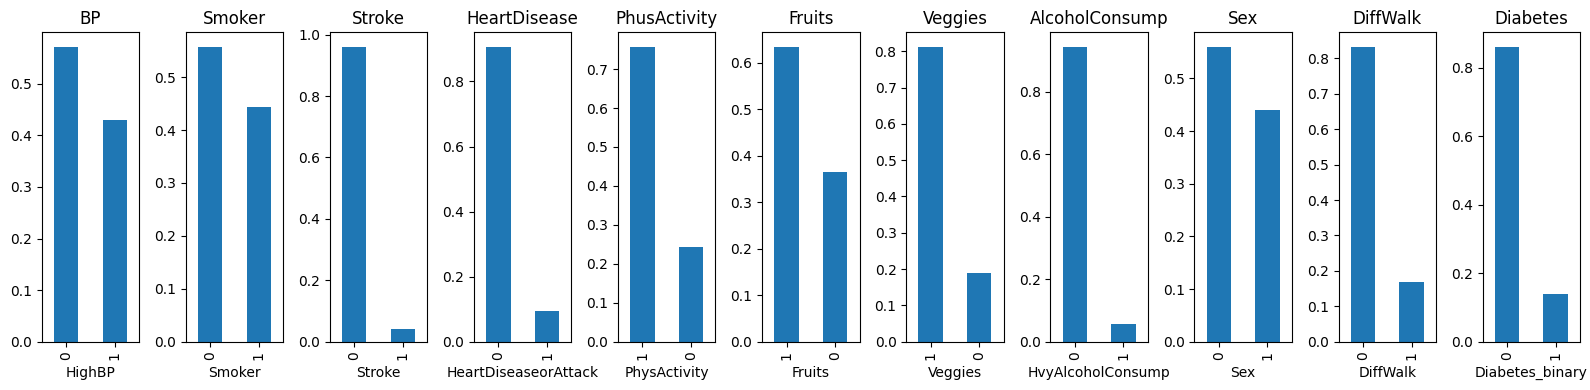

In [13]:
# Plot distribution of categorical features
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11) = plt.subplots(1, 11, figsize=(16,4))

df["HighBP"].value_counts(normalize=True).plot(kind="bar", ax=ax1, title="BP")
df["Smoker"].value_counts(normalize=True).plot(kind="bar", ax=ax2, title="Smoker")
df['Stroke'].value_counts(normalize=True).plot(kind="bar", ax=ax3, title="Stroke")
df['HeartDiseaseorAttack'].value_counts(normalize=True).plot(kind="bar", ax=ax4, title="HeartDisease")
df['PhysActivity'].value_counts(normalize=True).plot(kind="bar", ax=ax5, title="PhusActivity")
df['Fruits'].value_counts(normalize=True).plot(kind="bar", ax=ax6, title="Fruits")
df['Veggies'].value_counts(normalize=True).plot(kind="bar", ax=ax7, title="Veggies")
df['HvyAlcoholConsump'].value_counts(normalize=True).plot(kind="bar", ax=ax8, title="AlcoholConsump")
df['Sex'].value_counts(normalize=True).plot(kind="bar", ax=ax9, title="Sex")
df['DiffWalk'].value_counts(normalize=True).plot(kind="bar", ax=ax10, title="DiffWalk")
df['Diabetes_binary'].value_counts(normalize=True).plot(kind="bar", ax=ax11, title="Diabetes")

plt.tight_layout()
plt.show()

In [14]:
# Check overlap between PhysActivity and DiffWalk
pd.crosstab(df["PhysActivity"], df["DiffWalk"], normalize="index")

DiffWalk,0,1
PhysActivity,,
0,0.664832,0.335168
1,0.885499,0.114501


Only 11% of those with difficulty walking are physically active. Maybe this feature does not add a lot of new info? The relevance it has on diabetes is probably linked to lower physical activity, which means it is covered by that feature anyway. Then again, it may contain people that have difficulty walking *because* of their diabetes, e.g., becuause of neuropathy, which means it may be a usesful indicator on its own. 

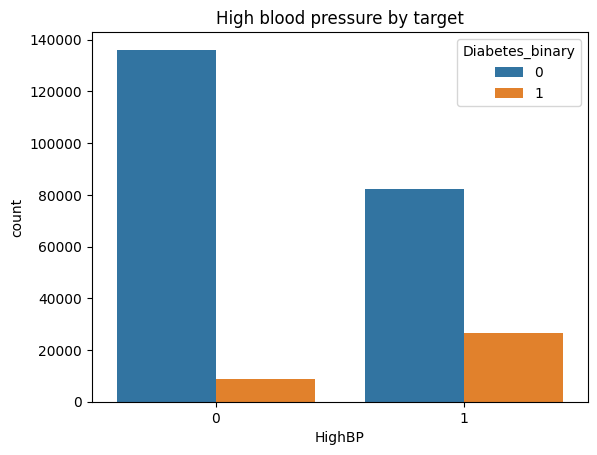

In [15]:
sns.countplot(data=df, x="HighBP", hue="Diabetes_binary")
plt.title("High blood pressure by target")
plt.show()

High blood pressure appear to be more common among those with diabets.

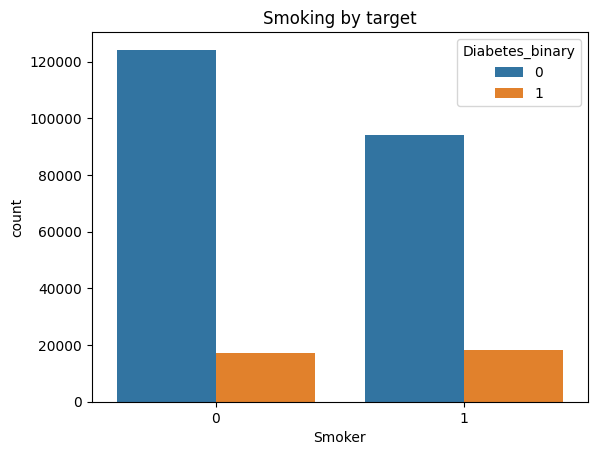

In [16]:
sns.countplot(data=df, x="Smoker", hue="Diabetes_binary")
plt.title("Smoking by target")
plt.show()

It seems somewhat more common that smokers have diabetes. 

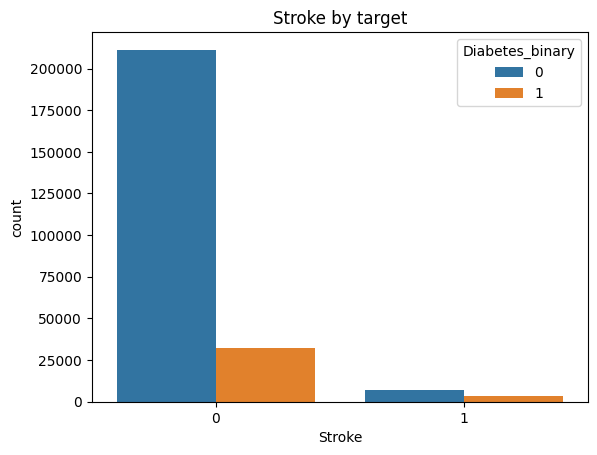

In [17]:
sns.countplot(data=df, x="Stroke", hue="Diabetes_binary")
plt.title("Stroke by target")
plt.show()

Overall, it is unusual for patients to have had a stroke. However, among patients with diabetes it appear to be relatively more common than among those that do not have diabetes. The y-axis is not optimal to determine this visually though, instead it would be advisable to look at the actual numbers. 

In [18]:
# Prevalence of diabetes among those with and without stroke
ct = pd.crosstab(df['Stroke'], df['Diabetes_binary']).reindex(index=[0,1], columns=[0,1], fill_value=0)
prev = (ct[1] / ct.sum(axis=1)) * 100
print(prev)  

Stroke
0    13.179779
1    31.752818
dtype: float64


Diabetes is more common among patients with prior stroke (~32%) than among those without (~13%) in this dataset

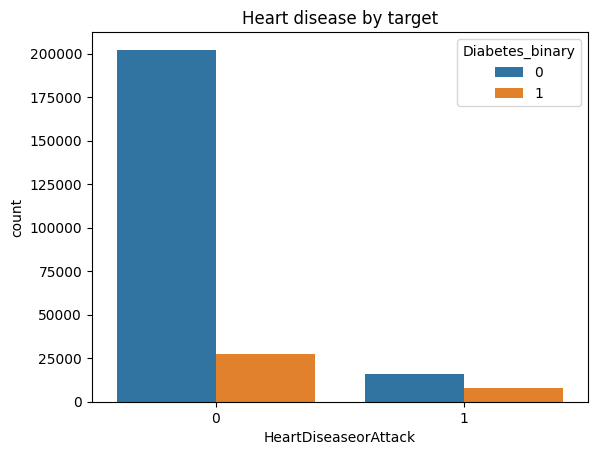

In [19]:
sns.countplot(data=df, x="HeartDiseaseorAttack", hue="Diabetes_binary")
plt.title("Heart disease by target")
plt.show()

In [20]:
# Prevalence of diabetes among those with and without heart disease
ct = pd.crosstab(df['HeartDiseaseorAttack'], df['Diabetes_binary']).reindex(index=[0,1], columns=[0,1], fill_value=0)
prev = (ct[1] / ct.sum(axis=1)) * 100
print(prev)  

HeartDiseaseorAttack
0    11.953679
1    32.972000
dtype: float64


Similar situation as stroke.

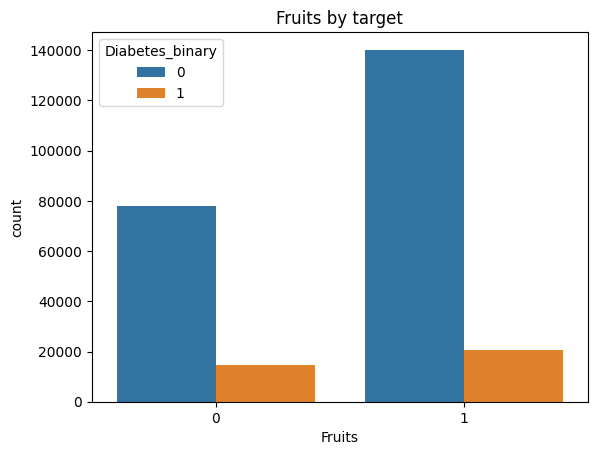

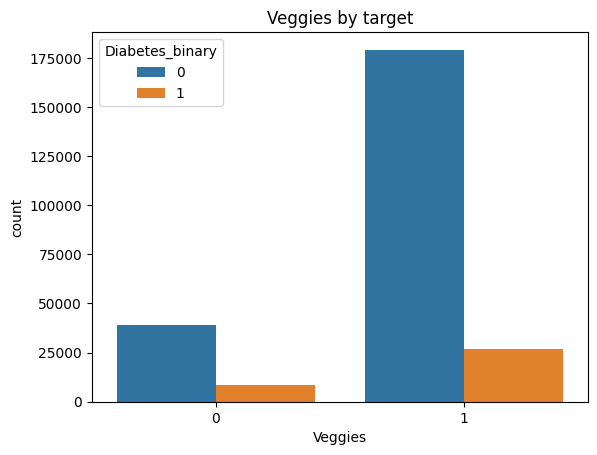

In [21]:
sns.countplot(data=df, x="Fruits", hue="Diabetes_binary")
plt.title("Fruits by target")
plt.show()

sns.countplot(data=df, x="Veggies", hue="Diabetes_binary")
plt.title("Veggies by target")
plt.show()

Similar patterns, but appear more common to eat vegetables daily. 

## Featues to consdier

**Fruits, Greens, PhysActivity**

The timing of data collection is not clearly specified. It is plausible that individuals who have lived with a diabetes diagnosis for some time may have already adjusted their diet and increased their consumption of fruits and vegetables. If so, this feature could misleadingly suggest a stronger association between green consumption and diabetes than what actually exists, thereby risking bias in the model.


## Q. How does incidence of diabetes vary with age?

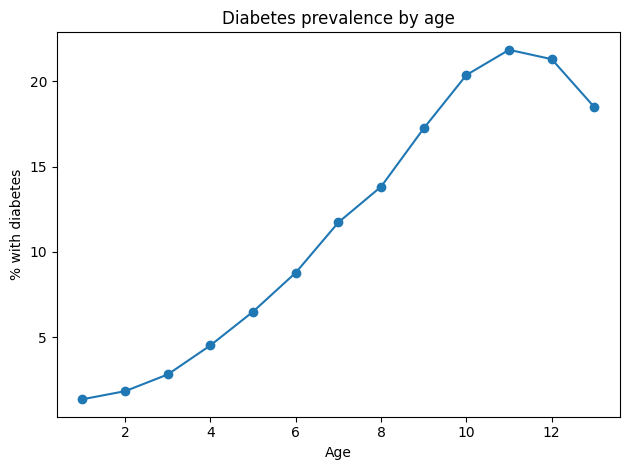

In [22]:
prev = df.groupby('Age')['Diabetes_binary'].mean() * 100

plt.plot(prev.index, prev.values, marker='o')
plt.xlabel('Age'); plt.ylabel('% with diabetes'); plt.title('Diabetes prevalence by age')
plt.tight_layout(); plt.show()

Diabetes seem to increase with age, until it reaches age group 10 (aroind 70 years old). After that it decreses again. 

# Binary features

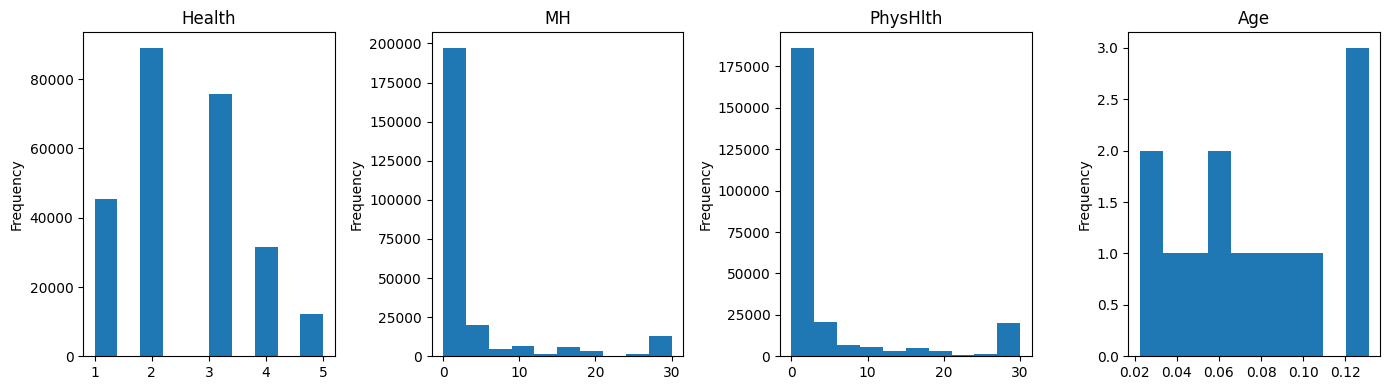

In [23]:
# Histograms of numerical features
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14,4))

df["GenHlth"].plot(kind="hist", ax=ax1, title="Health")
df["MentHlth"].plot(kind="hist", ax=ax2, title="MH")
df['PhysHlth'].plot(kind="hist", ax=ax3, title="PhysHlth")
df['Age'].value_counts(normalize=True).plot(kind="hist", ax=ax4, title="Age")

plt.tight_layout()
plt.show()

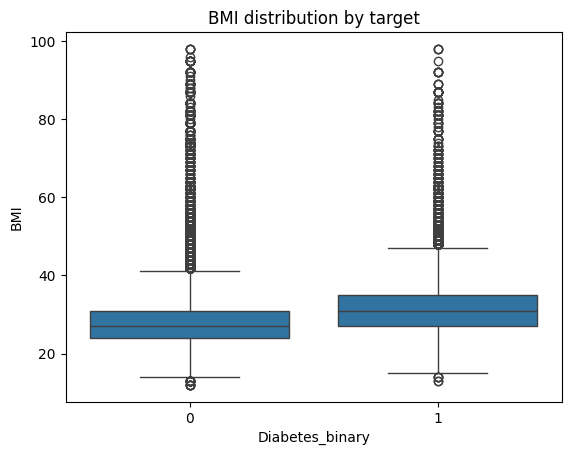

In [24]:
sns.boxplot(data=df, x="Diabetes_binary", y="BMI")
plt.title("BMI distribution by target")
plt.show()

The boxplot shows that the median BMI is clearly higher in the diabetes group compared to those without diabetes. However, the extreme outliers (BMI > 60–100) appear in both groups and do not provide meaningful separation between the two. This suggests that such extreme values act more as noise than as signal. In fact, the non diabetes group has higher outliers than the diabetes group, despite the fact that mean is slightly higher in the diabetes group. For a more accurate prediction it may be worthwile to limit BMI to the datapoints within the IQR range.

In [25]:
target = "Diabetes_binary"

corr = df.select_dtypes("number").corr(numeric_only=True)
cols = [target] + [c for c in corr.columns if c != target]
corr = corr.loc[cols, cols]

fig = px.imshow(
    corr,
    text_auto=".2f",
    color_continuous_scale="RdBu",
    zmin=-1, zmax=1,
    aspect="auto",
)
fig.update_layout(
    title="Correlation matrix",
    xaxis_title="", yaxis_title="",
    coloraxis_colorbar_title="corr",
    width=800, height=800,
)
fig.update_xaxes(side="top", tickangle=-45)
fig.show()

* Difficulties walking seem to be moderately assocatied with a poor general health.
* Poor physical health, poor mental health and poor general health all seem to have moderate correlation to eachother, the strongest association being poor physical health and poor general health.
* Physical activity seem to have a weak correlation to difficulty walking and poor physical health.
* General health has weak asociation woth physical activity. 
* No moderate or strong associations to target variable.

## Self reported health
The earlier correlation matrix indicated overlap between the self-reported health features. To assess whether they could be merged into a single feature, or if one or more could be removed, I plotted them side by side using boxplots for comparison. Since General Health is measured on a different scale (1–5) than Physical and Mental Health (0–30), I normalized all features to a 0–1 range to make their distributions directly comparable.

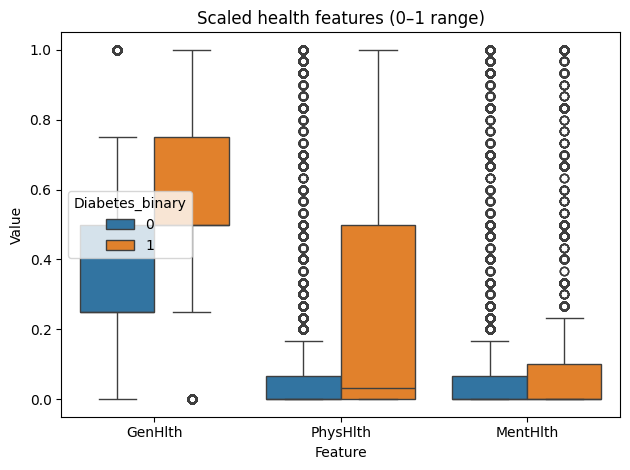

In [26]:
target_col = "Diabetes_binary"  
health_features = ["GenHlth", "PhysHlth", "MentHlth"]

df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[health_features] = scaler.fit_transform(df_scaled[health_features]) # Scale to 0-1 range to show all featueres on same scale

df_melted = df_scaled.melt(
    id_vars=target_col, value_vars=health_features,
    var_name="Feature", value_name="Value"
)

sns.boxplot(data=df_melted, x="Feature", y="Value", hue=target_col)
plt.title("Scaled health features (0–1 range)")
plt.tight_layout()
plt.show()

The distributions of Mental Health and Physical Health appear quite similar, and both are correlated with General Health. Moreover, the information captured by Physical Health may partly overlap with the Physical Activity variable, which could already account for limitations in daily functioning. Therefore, dropping Physical Health might simplify the model while retaining most of the relevant information, reducing redundancy between predictors.

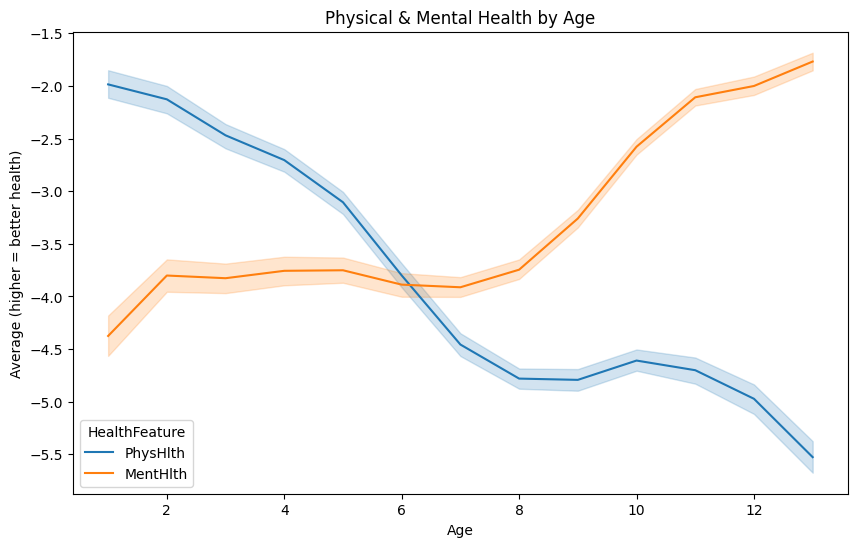

In [27]:
health_df = X[['Age', 'PhysHlth', 'MentHlth']].copy()

# Invert values as higher values indicate worse health
health_df['PhysHlth'] = -health_df['PhysHlth']
health_df['MentHlth'] = -health_df['MentHlth']

health_long = health_df.melt(
    id_vars="Age", 
    value_vars=["PhysHlth", "MentHlth"], 
    var_name="HealthFeature", 
    value_name="Score"
)

plt.figure(figsize=(10,6))
sns.lineplot(data=health_long, x="Age", y="Score", hue="HealthFeature", estimator="mean")
plt.title("Physical & Mental Health by Age")
plt.ylabel("Average (higher = better health)")
plt.show()


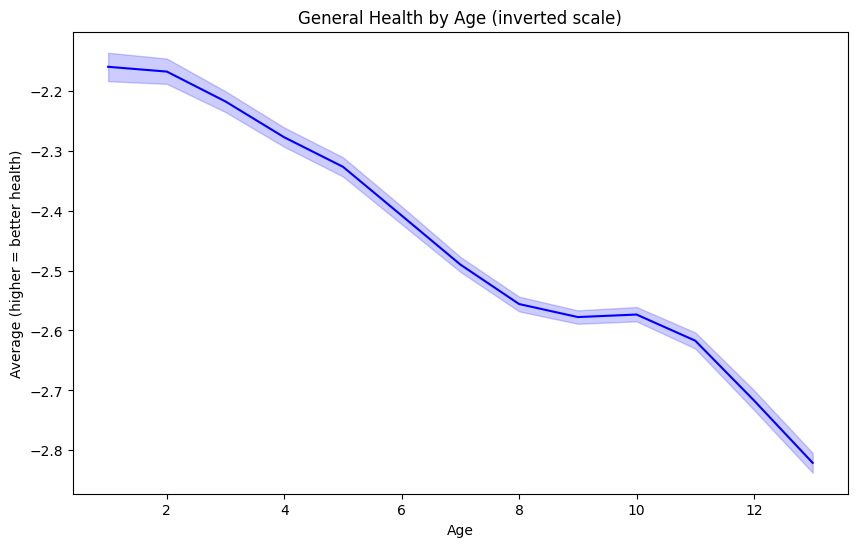

In [28]:
health_df = X[['Age', 'GenHlth']].copy()


health_df['GenHlth'] = -health_df['GenHlth']

plt.figure(figsize=(10,6))
sns.lineplot(data=health_df, x="Age", y="GenHlth", estimator="mean", color="blue")
plt.title("General Health by Age (inverted scale)")
plt.ylabel("Average (higher = better health)")
plt.show()


Physical health seem to follow almost exactly the same pattern as general health, i.e., gets worse with age. Mental health on the other hand gets better.

### Q. Does diabetes affect self reported health?

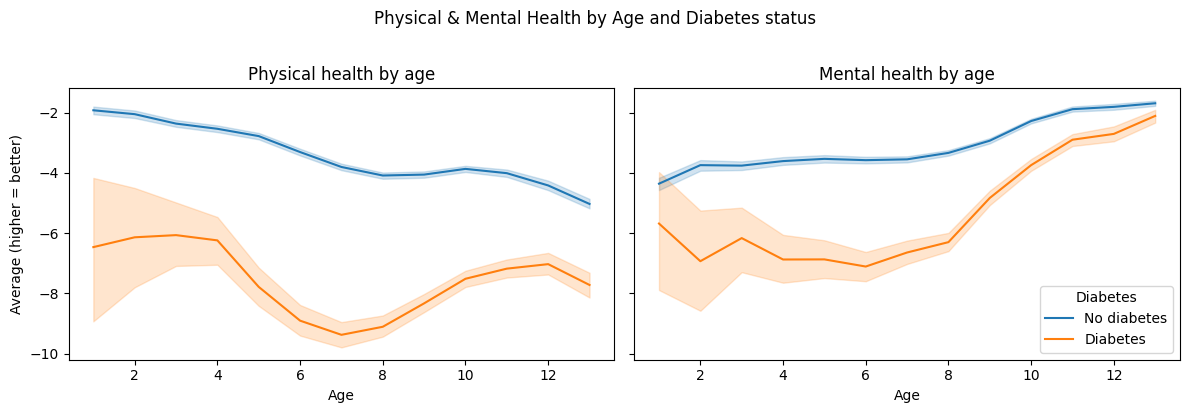

In [29]:
df_plot = df[['Age','PhysHlth','MentHlth','Diabetes_binary']].copy()
df_plot['PhysHlth'] = -df_plot['PhysHlth']   # Invert values as higher values indicate worse health
df_plot['MentHlth'] = -df_plot['MentHlth']
df_plot['Diabetes'] = np.where(df_plot['Diabetes_binary']==1, 'Diabetes', 'No diabetes')

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.lineplot(data=df_plot, x='Age', y='PhysHlth',
             hue='Diabetes', estimator='mean', ax=axes[0])
axes[0].set_title('Physical health by age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Average (higher = better)')

sns.lineplot(data=df_plot, x='Age', y='MentHlth',
             hue='Diabetes', estimator='mean', ax=axes[1])
axes[1].set_title('Mental health by age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('')

# one legend only
axes[0].legend_.remove()
axes[1].legend(title='Diabetes')

fig.suptitle('Physical & Mental Health by Age and Diabetes status', y=1.02)
plt.tight_layout()
plt.show()



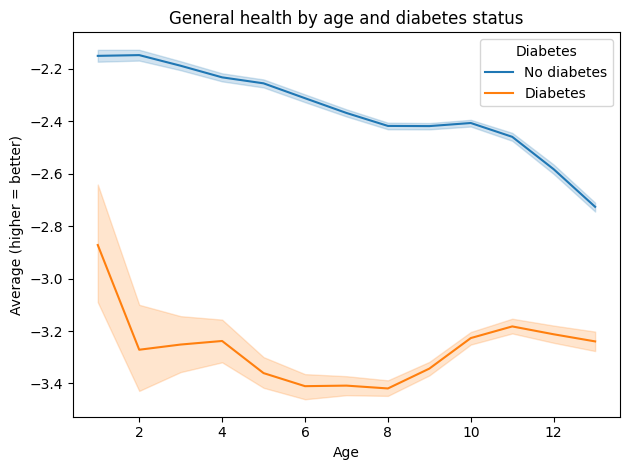

In [30]:
df_plot = df[['Age','GenHlth','Diabetes_binary']].copy()
df_plot['Diabetes'] = np.where(df_plot['Diabetes_binary']==1, 'Diabetes', 'No diabetes')
df_plot['GenHlth_score'] = -df_plot['GenHlth']  

sns.lineplot(data=df_plot, x='Age', y='GenHlth_score',
             hue='Diabetes', estimator='mean')
plt.title('General health by age and diabetes status')
plt.xlabel('Age'); plt.ylabel('Average (higher = better)')
plt.tight_layout(); plt.show()



Overall, patients with diabetes seem to report worse health. However, older patients with diabetes report almost the same mental health level as those without diabetes. 

In [31]:
# Ensuring X has not been modiofied during EDA
X.head()

,HighBP,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,1,40,1,0,0,0,0,1,0,5,18,15,1,0,9
1,0,25,1,0,0,1,0,0,0,3,0,0,0,0,7
2,1,28,0,0,0,0,1,0,0,5,30,30,1,0,9
3,1,27,0,0,0,1,1,1,0,2,0,0,0,0,11
4,1,24,0,0,0,1,1,1,0,2,3,0,0,0,11


<Axes: title={'center': 'Diabetes'}, xlabel='Diabetes_binary'>

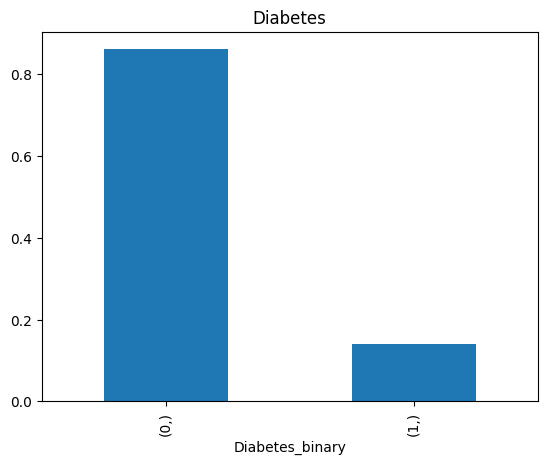

In [32]:
y.value_counts(normalize=True).plot(kind="bar", title="Diabetes")

# Model traininh - All features included

In [33]:
X_ml = X.to_numpy()
y_ml = y.to_numpy().ravel()

In [34]:
print(y_ml.shape)

(253680,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.2, stratify=y_ml, random_state=42
)


In [36]:
X_small, _, y_small, _ = train_test_split(
    X_train, y_train, train_size=20000, stratify=y_train, random_state=42
)


Because of the large dataset I will start by training on a small subset (n=20 000). Based on the result I will move on with the best model and train on the whole dataset.

## Attempt using GridSearchCV

In [37]:
# Trainign using gridsearchcv
X_small, _, y_small, _ = train_test_split(X_ml, y_ml, train_size=20000, stratify=y_ml, random_state=42)
sw_balanced = compute_sample_weight("balanced", y_small)
pos = int((y_small == 1).sum())
neg = int((y_small == 0).sum())
scale_pos = (neg / pos) if pos else 1.0

models_and_grids = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        {
            "clf__criterion": ["gini","entropy","log_loss"],
            "clf__max_depth": [4,6,8,10],
            "clf__min_samples_leaf": [5,10,20]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced_subsample", max_features="sqrt"),
        {
            "clf__n_estimators": [300,600],
            "clf__max_depth": [6,8,None],
            "clf__min_samples_leaf": [5,10,20]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [200,400],
            "clf__max_depth": [3,4],
            "clf__min_samples_leaf": [10,20],
            "clf__learning_rate": [0.05,0.1]
        }
    ),
    "HistGradientBoosting": (
        HistGradientBoostingClassifier(random_state=42, early_stopping=False),
        {
            "clf__max_depth": [3,5],
            "clf__min_samples_leaf": [10,20,30],
            "clf__l2_regularization": [0.0,1.0]
        }
    ),
    "XGBoost": (
        XGBClassifier(
            eval_metric="aucpr", random_state=42, n_jobs=-1, scale_pos_weight=scale_pos, tree_method="hist"
        ),
        {
            "clf__n_estimators": [300,600],
            "clf__max_depth": [3,4],
            "clf__min_child_weight": [5,10],
            "clf__gamma": [0,1.0],
            "clf__subsample": [0.8,1.0],
            "clf__colsample_bytree": [0.8,1.0],
            "clf__learning_rate": [0.05,0.1],
            "clf__reg_lambda": [1.0,2.0]
        }
    ),
    "SVM (linear)": (
        SVC(kernel="linear", probability=False, random_state=42, class_weight="balanced"),
        {"clf__C": [0.1,0.3,1.0]}
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=2000, solver="liblinear", random_state=42, class_weight="balanced"),
        {"clf__C": [0.1,0.3,1.0], "clf__penalty": ["l1","l2"]}
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc"
}

def needs_scaling(name):
    return name in {"SVM (linear)", "Logistic Regression"}

def supports_sample_weight(name):
    return name in {"Decision Tree","Random Forest","Gradient Boosting","HistGradientBoosting","XGBoost","SVM (linear)","Logistic Regression"}

results = []
best_estimators = {}

for name, (clf, param_grid) in models_and_grids.items():
    steps = [("scaler", StandardScaler() if needs_scaling(name) else "passthrough"), ("clf", clf)]
    pipe = Pipeline(steps)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=scoring, refit="f1", n_jobs=-1)
    fit_params = {"clf__sample_weight": sw_balanced} if supports_sample_weight(name) else {}
    grid.fit(X_small, y_small, **fit_params)
    results.append({
        "model": name,
        "best_parameters": grid.best_params_,
        "best_f1": grid.best_score_,
        "cv_precision": grid.cv_results_["mean_test_precision"][grid.best_index_],
        "cv_recall": grid.cv_results_["mean_test_recall"][grid.best_index_]
    })
    best_estimators[name] = grid.best_estimator_

results_df = pd.DataFrame(results).sort_values(["best_f1","cv_recall","cv_precision"], ascending=False)
results_df

,model,best_parameters,best_f1,cv_precision,cv_recall
2,Gradient Boosting,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",0.440685,0.308804,0.769638
3,HistGradientBoosting,"{'clf__l2_regularization': 1.0, 'clf__max_dept...",0.440077,0.308136,0.770001
6,Logistic Regression,"{'clf__C': 1.0, 'clf__penalty': 'l1'}",0.439197,0.307945,0.765687
1,Random Forest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.403357,0.264541,0.848931
4,XGBoost,"{'clf__colsample_bytree': 1.0, 'clf__gamma': 1...",0.359239,0.223426,0.916388
0,Decision Tree,"{'clf__criterion': 'gini', 'clf__max_depth': 1...",0.336486,0.207107,0.897020
5,SVM (linear),{'clf__C': 0.1},0.244613,0.139350,1.000000


### Confusion Matrix for best 4

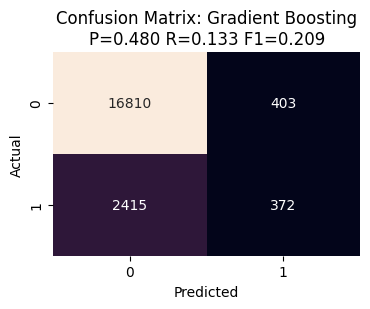

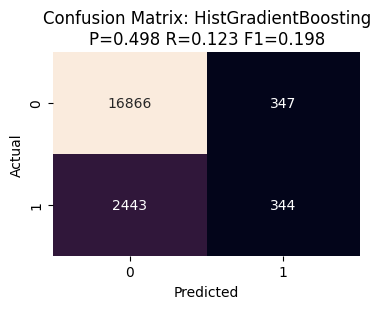

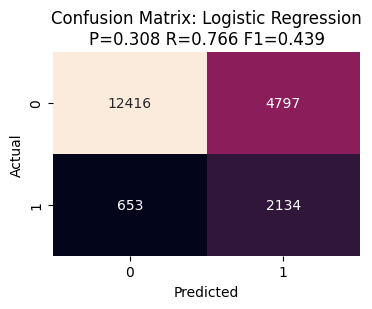

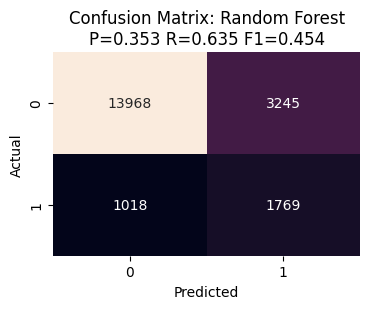

In [38]:
top_models = results_df.sort_values("best_f1", ascending=False)["model"].head(4).tolist()


conf_mats = {}
for name in top_models:
    est = best_estimators[name]
    y_pred = cross_val_predict(est, X_small, y_small, cv=cv, n_jobs=-1)
    cm = confusion_matrix(y_small, y_pred, labels=[0,1])
    conf_mats[name] = cm

    tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_small, y_pred, zero_division=0)
    rec  = recall_score(y_small, y_pred, zero_division=0)
    f1   = f1_score(y_small, y_pred, zero_division=0)

    plt.figure(figsize=(3.8,3.2))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"Confusion Matrix: {name}\nP={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Logistic regression and RF have decent recall, at the expense of precision. 

### Feature importance


=== Classification report (CV OOF): Decision Tree ===
              precision    recall  f1-score   support

           0      0.939     0.695     0.798     17213
           1      0.276     0.720     0.400      2787

    accuracy                          0.698     20000
   macro avg      0.608     0.708     0.599     20000
weighted avg      0.847     0.698     0.743     20000



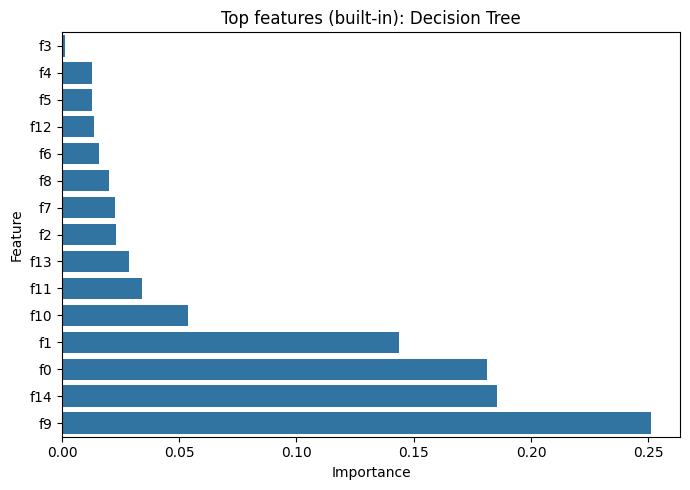


=== Classification report (CV OOF): Random Forest ===
              precision    recall  f1-score   support

           0      0.932     0.811     0.868     17213
           1      0.353     0.635     0.454      2787

    accuracy                          0.787     20000
   macro avg      0.642     0.723     0.661     20000
weighted avg      0.851     0.787     0.810     20000



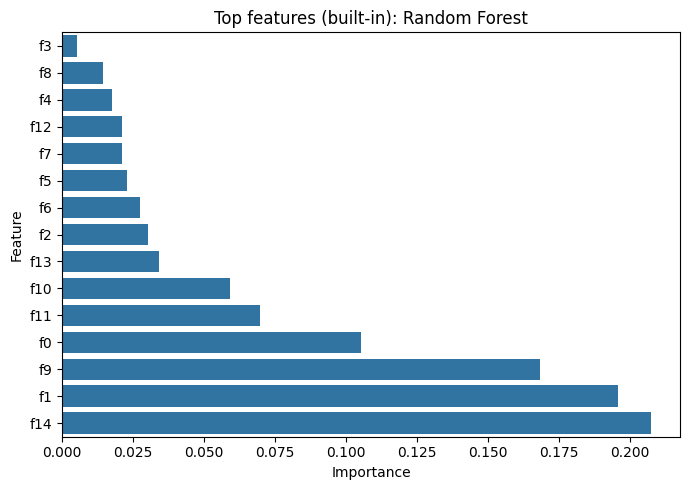


=== Classification report (CV OOF): Gradient Boosting ===
              precision    recall  f1-score   support

           0      0.874     0.977     0.923     17213
           1      0.480     0.133     0.209      2787

    accuracy                          0.859     20000
   macro avg      0.677     0.555     0.566     20000
weighted avg      0.819     0.859     0.823     20000



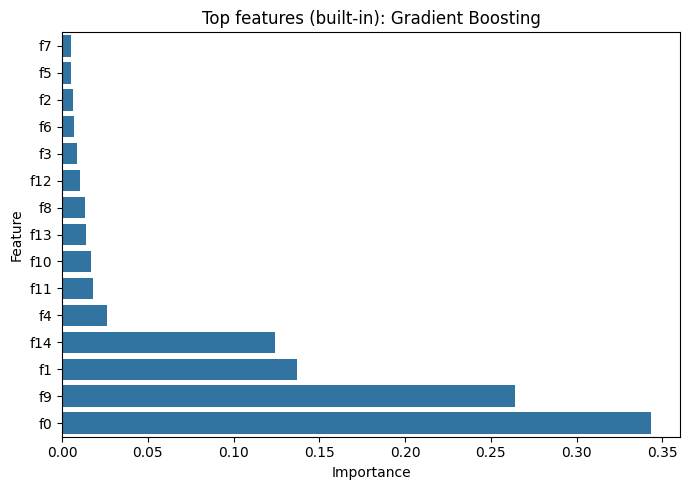


=== Classification report (CV OOF): XGBoost ===
              precision    recall  f1-score   support

           0      0.943     0.745     0.832     17213
           1      0.314     0.720     0.437      2787

    accuracy                          0.741     20000
   macro avg      0.628     0.732     0.635     20000
weighted avg      0.855     0.741     0.777     20000



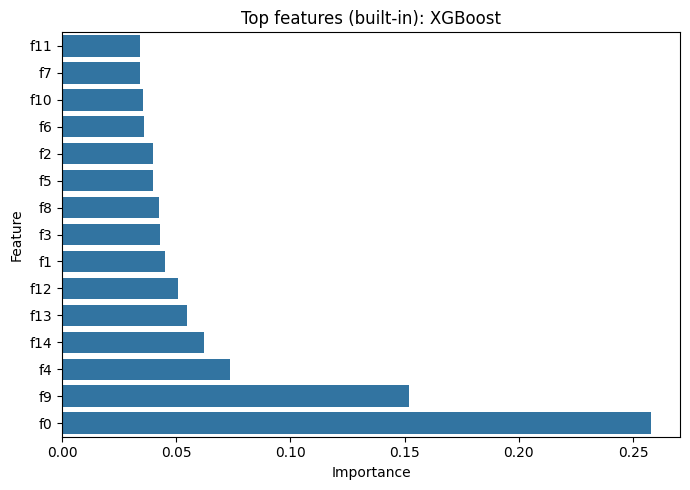


=== Classification report (CV OOF): SVM (linear) ===
              precision    recall  f1-score   support

           0      0.954     0.689     0.800     17213
           1      0.293     0.797     0.428      2787

    accuracy                          0.704     20000
   macro avg      0.624     0.743     0.614     20000
weighted avg      0.862     0.704     0.748     20000



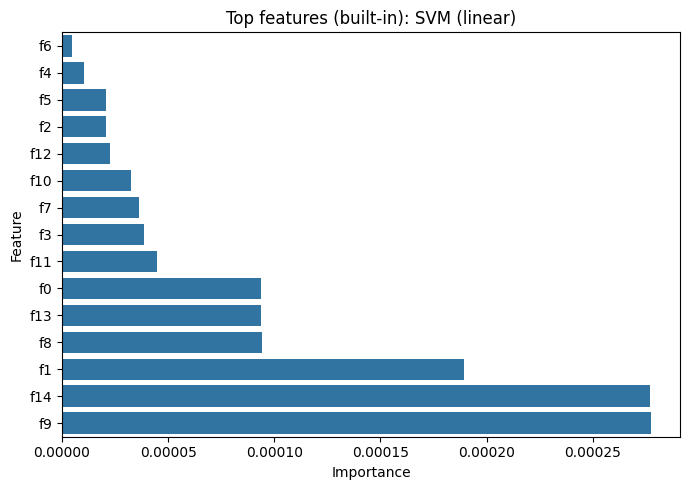


=== Classification report (CV OOF): Logistic Regression ===
              precision    recall  f1-score   support

           0      0.950     0.721     0.820     17213
           1      0.308     0.766     0.439      2787

    accuracy                          0.728     20000
   macro avg      0.629     0.744     0.630     20000
weighted avg      0.861     0.728     0.767     20000



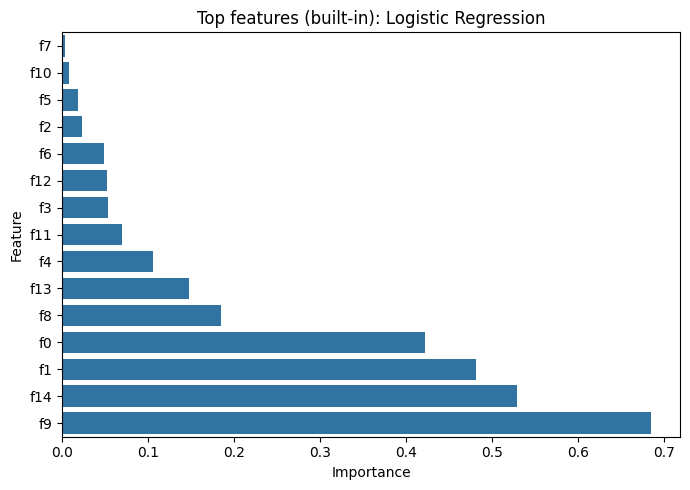

In [39]:
# This was copy pasted from ChatGPT
def get_feature_names(X):
    return X.columns.tolist() if isinstance(X, pd.DataFrame) else [f"f{i}" for i in range(X.shape[1])]

feature_names = get_feature_names(X_small)

def builtin_importance_from_pipeline(pipe, feature_names):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        imp = np.asarray(clf.feature_importances_, dtype=float)
        return pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
    if hasattr(clf, "coef_"):
        coef = clf.coef_
        coef = np.mean(np.abs(coef), axis=0) if coef.ndim > 1 else np.abs(coef)
        imp = np.asarray(coef, dtype=float)
        return pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
    if hasattr(clf, "get_booster"):
        booster = clf.get_booster()
        score = booster.get_score(importance_type="gain")
        imp = np.array([score.get(f"f{i}", 0.0) for i in range(len(feature_names))], dtype=float)
        return pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
    return None

models_with_importance = []
for name, pipe in best_estimators.items():
    if builtin_importance_from_pipeline(pipe, feature_names) is not None:
        models_with_importance.append(name)

for name in models_with_importance:
    pipe = best_estimators[name]
    y_pred = cross_val_predict(pipe, X_small, y_small, cv=cv, n_jobs=-1)
    print(f"\n=== Classification report (CV OOF): {name} ===")
    print(classification_report(y_small, y_pred, digits=3))

    imp_df = builtin_importance_from_pipeline(pipe, feature_names)
    topk = imp_df.head(15).iloc[::-1]
    plt.figure(figsize=(7,5))
    sns.barplot(data=topk, x="importance", y="feature", orient="h")
    plt.title(f"Top features (built-in): {name}")
    plt.xlabel("Importance"); plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

## Attempt with dict like in DSHI

In [40]:
scaler = StandardScaler()

X_small = scaler.fit_transform(X_small)
X_small = scaler.transform(X_small)
     

In [41]:
# Dict of classifiers with tuned hyperparameters
classifiers = {
    "Decision Tree (depth=10)": DecisionTreeClassifier(
        max_depth=5, 
        min_samples_leaf=20,             
        class_weight="balanced", 
        random_state=42
    ),

    "Decision Tree (depth=5)": DecisionTreeClassifier(
        max_depth=None, 
        min_samples_leaf=20,             
        class_weight="balanced", 
        random_state=42
    ),

    "Random Forest (600 trees)": RandomForestClassifier(
        n_estimators=600, 
        max_depth=8,                 
        min_samples_leaf=5, 
        class_weight="balanced_subsample",
        max_features="sqrt",
        n_jobs=-1, 
        random_state=42
    ),

    "Random Forest (200 trees)": RandomForestClassifier(
        n_estimators=400, 
        max_depth=10, 
        min_samples_leaf=10, 
        class_weight="balanced_subsample",
        max_features="sqrt",
        n_jobs=-1, 
        random_state=42
    ),

    "SVM (rbf)": SVC(
        kernel='rbf', 
        C=0.7,                           
        gamma='scale',                  
        class_weight='balanced',         
        probability=True,                
        random_state=42
    ),

    "SVM (linear)": SVC(
        kernel='linear', 
        C=0.2,                           
        class_weight='balanced', 
        probability=True,
        random_state=42
    ),

    "LogReg (L2)": LogisticRegression(
        penalty='l2', 
        C=0.3,                           
        class_weight='balanced', 
        solver='liblinear', 
        max_iter=2000,
        random_state=42
    ),

    "LogReg (L1)": LogisticRegression(
        penalty='l1', 
        C=0.7, 
        class_weight='balanced', 
        solver='liblinear', 
        max_iter=2000,
        random_state=42
    ),

   
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=3,
        max_leaf_nodes=None,
        min_samples_leaf=20,                   
        learning_rate=0.08,             
        max_iter=300,                    
        early_stopping=False,            
        l2_regularization=1.0, 
        max_bins=255,
        random_state=42
    ),

    
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        reg_lambda=2.0,
        eval_metric="aucpr",             
        scale_pos_weight=9,     
        n_jobs=-1,
        random_state=42
    ),
}

In [42]:
# Define which metrics to track during cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = []

# Loop through each classifier
for name, clf in classifiers.items():
    # Start timer for training + cross-validated prediction
    t_start = time.time()

    # Perform 5-fold cross-validation
    scores = cross_validate(
        clf,
        X_small,
        y_small,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    t_end = time.time()

    # Estimate total time and split roughly 50/50 between training and prediction
    total_time = t_end - t_start
    training_time = total_time / 2
    prediction_time = total_time / 2

    # Save mean scores across all folds
    result = {
        "classifier_name": name,
        "training_time": round(training_time, 4),
        "prediction_time": round(prediction_time, 4),
        "accuracy": scores['test_accuracy'].mean(),
        "precision": scores['test_precision'].mean(),
        "recall": scores['test_recall'].mean(),
        "f1": scores['test_f1'].mean()
    }

    cv_results.append(result)

# Convert results to DataFrame
results = pd.DataFrame(cv_results)
results

,classifier_name,training_time,prediction_time,accuracy,precision,recall,f1
0,Decision Tree (depth=10),0.0578,0.0578,0.67920,0.276875,0.804104,0.411594
1,Decision Tree (depth=5),0.0790,0.0790,0.69930,0.277206,0.717979,0.399780
2,Random Forest (600 trees),5.7238,5.7238,0.73300,0.310374,0.747767,0.438579
3,Random Forest (200 trees),3.7624,3.7624,0.73900,0.314285,0.736646,0.440489
4,SVM (rbf),95.6209,95.6209,0.67315,0.270816,0.794052,0.403849
5,SVM (linear),58.3841,58.3841,0.70415,0.293286,0.796205,0.428648
6,LogReg (L2),0.1593,0.1593,0.72230,0.300999,0.750630,0.429667
7,LogReg (L1),8.8978,8.8978,0.72785,0.307890,0.763191,0.438739
8,HistGradientBoosting,0.8743,0.8743,0.86140,0.510347,0.134551,0.212628
9,XGBoost,0.6383,0.6383,0.66540,0.273833,0.848224,0.413991


## Attempt 2, leaner model

Based on EDA a smaller set of input variables are suggested.

In [43]:
X["BMI_core"] = X["BMI"].clip(lower=15, upper=60)
X = X.drop(columns=['BMI'])
X.head()

,HighBP,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,BMI_core
0,1,1,0,0,0,0,1,0,5,18,15,1,0,9,40
1,0,1,0,0,1,0,0,0,3,0,0,0,0,7,25
2,1,0,0,0,0,1,0,0,5,30,30,1,0,9,28
3,1,0,0,0,1,1,1,0,2,0,0,0,0,11,27
4,1,0,0,0,1,1,1,0,2,3,0,0,0,11,24


In [44]:
X_lean = X[['HighBP', 'BMI_core', 'HeartDiseaseorAttack', 'GenHlth', 'Age', 'PhysActivity']]

In [45]:
X_lean = X_lean.to_numpy()
y_lean = y.to_numpy().ravel()

In [46]:
X_traim, X_test, y_train, y_test = train_test_split(
    X_lean, y_lean, test_size=0.2, stratify=y_lean, random_state=42
)

In [47]:
X_small, _, y_small, _ = train_test_split(
    X_traim, y_train, train_size=20000, stratify=y_train, random_state=42
)

## GridSearch

In [48]:
pos = (y_small == 1).sum()
neg = (y_small == 0).sum()
scale_pos = (neg / pos) if pos else 1.0                
sw_balanced = compute_sample_weight("balanced", y_small)

models_and_grids = {
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        {"clf__max_depth": [3, 5, 10]}
    ),
    "Random Forest": (
        RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced"),
        {"clf__n_estimators": [200, 500], "clf__max_depth": [5, 8]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {"clf__n_estimators": [100, 200], "clf__max_depth": [3, 5]}
    ),
    "HistGradientBoosting": (
        HistGradientBoostingClassifier(random_state=42),
        {"clf__max_depth": [3, 5]}
    ),
    "XGBoost": (
        XGBClassifier(eval_metric="aucpr", random_state=42, n_jobs=-1, scale_pos_weight=scale_pos),
        {"clf__n_estimators": [100, 200], "clf__max_depth": [3, 5]}
    ),
    "SVM (linear)": (
        SVC(kernel="linear", probability=False, random_state=42, class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=500, solver="liblinear", random_state=42, class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc", "f1": "f1"}

results = []
for name, (clf, param_grid) in models_and_grids.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=scoring, refit='f1', n_jobs=-1)
    fit_params = {}
    if name in ['Gradient Boosting', 'HistGradientBoosting']:
        fit_params = {"clf__sample_weight": sw_balanced}

    grid.fit(X_small, y_small, **fit_params)
    results.append({
    "model": name,
    "best_parameters": grid.best_params_,
    "best_f1": grid.best_score_
})


results_df = pd.DataFrame(results)
results_df

,model,best_parameters,best_f1
0,Decision Tree,{'clf__max_depth': 5},0.410940
1,Random Forest,"{'clf__max_depth': 8, 'clf__n_estimators': 200}",0.429259
2,Gradient Boosting,"{'clf__max_depth': 3, 'clf__n_estimators': 100}",0.427832
3,HistGradientBoosting,{'clf__max_depth': 3},0.428132
4,XGBoost,"{'clf__max_depth': 3, 'clf__n_estimators': 100}",0.424090
5,SVM (linear),{'clf__C': 0.1},0.416047
6,Logistic Regression,{'clf__C': 10},0.428119


### DSHI method

In [51]:
X_small = scaler.fit_transform(X_small)
X_small = scaler.transform(X_small)
     

In [52]:
# Define which metrics to track during cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = []

# Loop through each classifier
for name, clf in classifiers.items():
    # Start timer for training + cross-validated prediction
    t_start = time.time()

    # Perform 5-fold cross-validation
    scores = cross_validate(
        clf,
        X_small,
        y_small,
        cv=5,
        scoring=scoring,
        return_train_score=False
    )

    t_end = time.time()

    # Estimate total time and split roughly 50/50 between training and prediction
    total_time = t_end - t_start
    training_time = total_time / 2
    prediction_time = total_time / 2

    # Save mean scores across all folds
    result = {
        "classifier_name": name,
        "training_time": round(training_time, 4),
        "prediction_time": round(prediction_time, 4),
        "accuracy": scores['test_accuracy'].mean(),
        "precision": scores['test_precision'].mean(),
        "recall": scores['test_recall'].mean(),
        "f1": scores['test_f1'].mean()
    }

    cv_results.append(result)

# Convert results to DataFrame
results = pd.DataFrame(cv_results)
results

,classifier_name,training_time,prediction_time,accuracy,precision,recall,f1
0,Decision Tree (depth=10),0.0312,0.0312,0.68585,0.277500,0.780765,0.409315
1,Decision Tree (depth=5),0.0359,0.0359,0.69530,0.275392,0.725143,0.399049
2,Random Forest (600 trees),3.9509,3.9509,0.72150,0.300406,0.751339,0.429195
3,Random Forest (200 trees),2.5475,2.5475,0.72140,0.298350,0.738787,0.425007
4,SVM (rbf),70.1554,70.1554,0.67470,0.268425,0.772152,0.398311
5,SVM (linear),34.7821,34.7821,0.69595,0.283747,0.773951,0.415160
6,LogReg (L2),0.0503,0.0503,0.71875,0.296606,0.741297,0.423600
7,LogReg (L1),3.5782,3.5782,0.72025,0.298532,0.744527,0.426043
8,HistGradientBoosting,0.5798,0.5798,0.86580,0.578913,0.137420,0.222083
9,XGBoost,0.4519,0.4519,0.64330,0.261490,0.854678,0.400432


Smaller dataset does not seem to make a difference in performance at this point, but may be warranted from usability pov and to keep computational cost down.

# References

1. https://www.1177.se/Stockholm/sa-fungerar-varden/att-valja-vardmottagning/valja-vardmottagning/om-listning-och-avlistning/
2. https://www.informationsverige.se/sv/jag-har-fatt-uppehallstillstand/om-du-behover-vard.html/
